<a href="https://colab.research.google.com/github/Maxxx-VS/IT_food/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D0%B8%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Корреляционно-регрессионный анализ

### Гипотеза 1: Качество вина (quality) положительно коррелирует с содержанием алкоголя (alcohol) и отрицательно — с летучими кислотами (volatile acidity).

###  Гипотеза 2: Существует мультиколлинеарность между химическими показателями (например, плотность (density) сильно зависит от остаточного сахара (residual sugar) и содержания алкоголя (alcohol)).

In [ ]:
# Шаг 1: Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Установка стиля графиков
plt.style.use('seaborn-v0_8')

In [ ]:
# Шаг 2: Загрузка данных
# Чтение файла
df = pd.read_csv('winequality-red.csv', sep=',')

# Шаг 3: Первичный анализ
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

Размер датасета: (1599, 12)

Первые 5 строк:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5

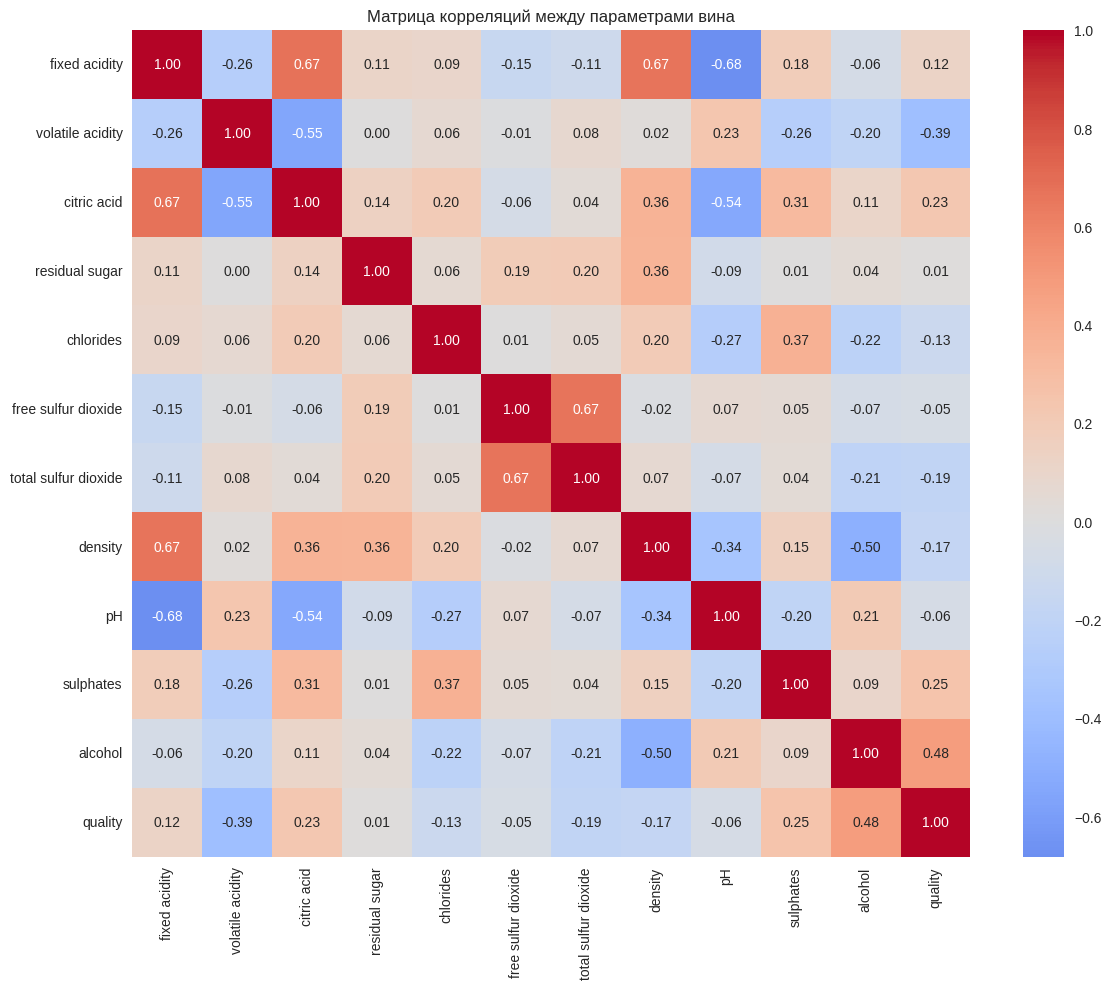

Корреляция признаков с качеством вина:
quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


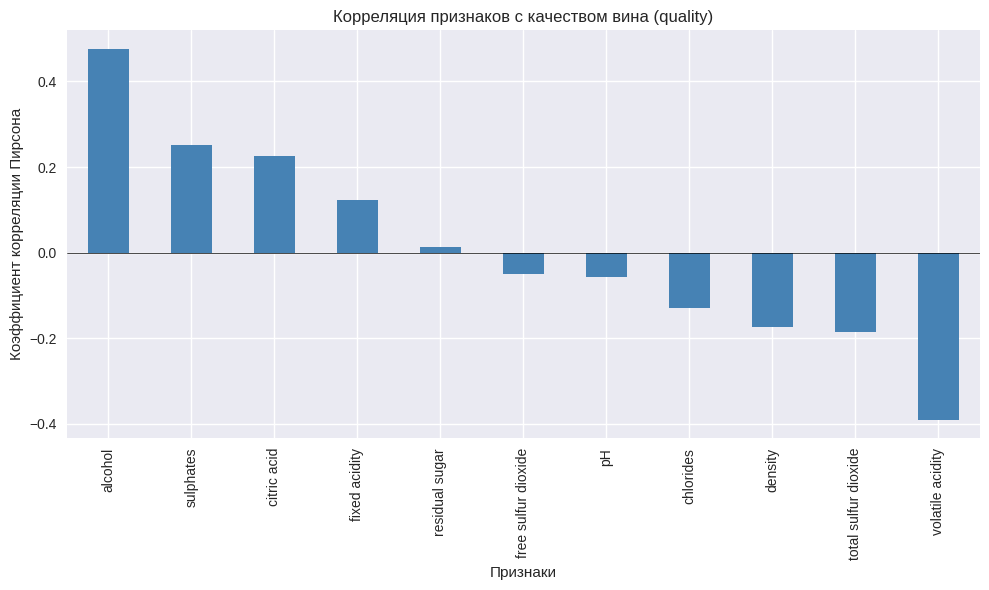

In [ ]:
# Шаг 4: Построение матрицы корреляций
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций между параметрами вина')
plt.tight_layout()
plt.show()

# Шаг 5: Анализ корреляций с целевой переменной (quality)
quality_corr = correlation_matrix['quality'].sort_values(ascending=False)
print("Корреляция признаков с качеством вина:")
print(quality_corr)

# Визуализация топ-коррелирующих признаков
plt.figure(figsize=(10, 6))
quality_corr.drop('quality').plot(kind='bar', color='steelblue')
plt.title('Корреляция признаков с качеством вина (quality)')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент корреляции Пирсона')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

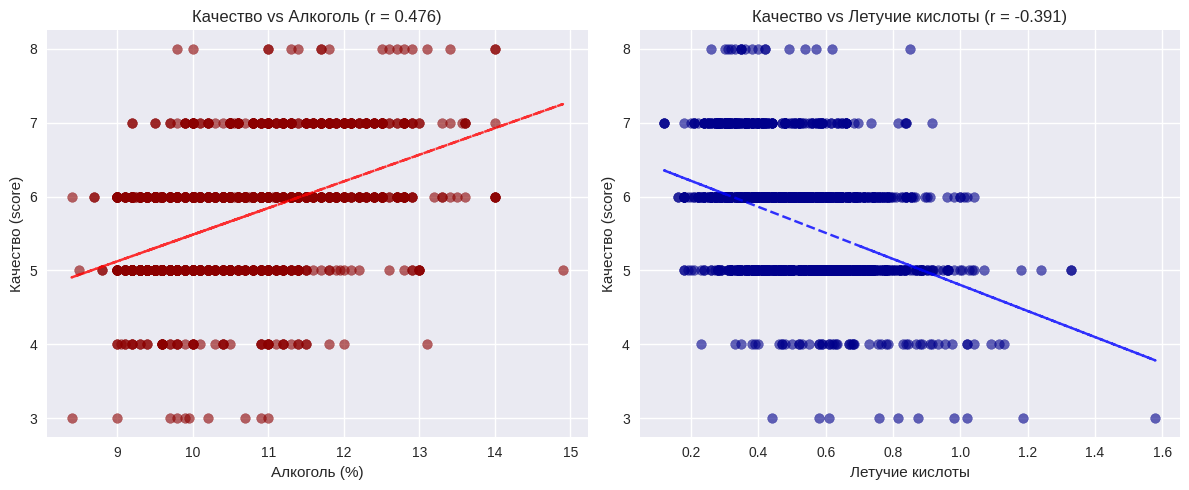

Корреляция alcohol-quality: 0.476
Корреляция volatile acidity-quality: -0.391


In [ ]:
# Шаг 6: Проверка первой гипотезы
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Качество vs Алкоголь
axes[0].scatter(df['alcohol'], df['quality'], alpha=0.6, color='darkred')
axes[0].set_xlabel('Алкоголь (%)')
axes[0].set_ylabel('Качество (score)')
axes[0].set_title(f'Качество vs Алкоголь (r = {correlation_matrix.loc["alcohol", "quality"]:.3f})')
z = np.polyfit(df['alcohol'], df['quality'], 1)
p = np.poly1d(z)
axes[0].plot(df['alcohol'], p(df['alcohol']), "r--", alpha=0.8)

# Качество vs Летучие кислоты
axes[1].scatter(df['volatile acidity'], df['quality'], alpha=0.6, color='darkblue')
axes[1].set_xlabel('Летучие кислоты')
axes[1].set_ylabel('Качество (score)')
axes[1].set_title(f'Качество vs Летучие кислоты (r = {correlation_matrix.loc["volatile acidity", "quality"]:.3f})')
z = np.polyfit(df['volatile acidity'], df['quality'], 1)
p = np.poly1d(z)
axes[1].plot(df['volatile acidity'], p(df['volatile acidity']), "b--", alpha=0.8)

plt.tight_layout()
plt.show()

print(f"Корреляция alcohol-quality: {correlation_matrix.loc['alcohol', 'quality']:.3f}")
print(f"Корреляция volatile acidity-quality: {correlation_matrix.loc['volatile acidity', 'quality']:.3f}")

Пары признаков с высокой корреляцией (> |0.7|):


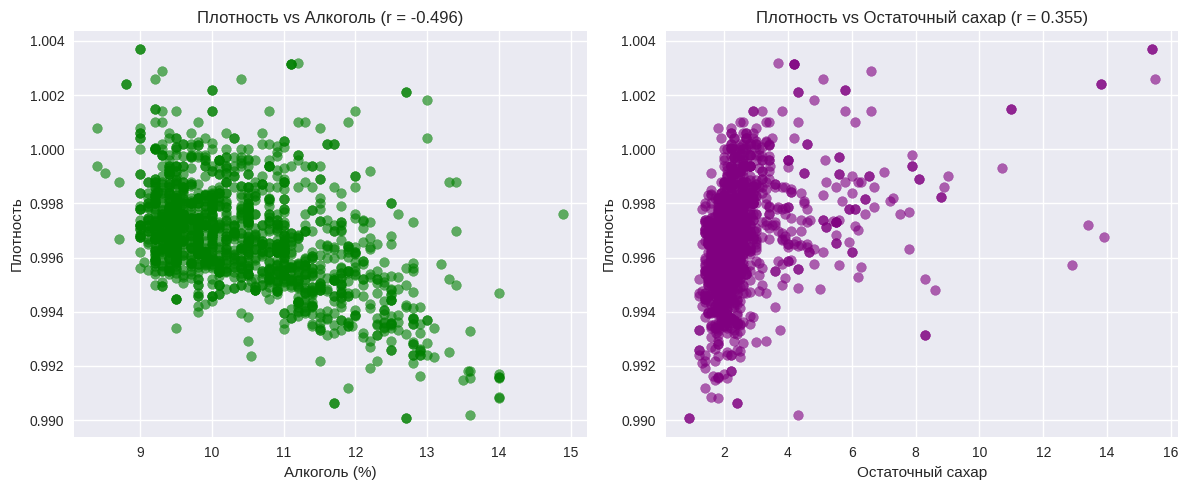

In [ ]:
# Шаг 7: Проверка второй гипотезы
# Анализ корреляции между химическими параметрами
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7 and i != j:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("Пары признаков с высокой корреляцией (> |0.7|):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

# Визуализация ключевой зависимости: density vs alcohol/residual sugar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Плотность vs Алкоголь
axes[0].scatter(df['alcohol'], df['density'], alpha=0.6, color='green')
axes[0].set_xlabel('Алкоголь (%)')
axes[0].set_ylabel('Плотность')
axes[0].set_title(f'Плотность vs Алкоголь (r = {correlation_matrix.loc["alcohol", "density"]:.3f})')

# Плотность vs Остаточный сахар
axes[1].scatter(df['residual sugar'], df['density'], alpha=0.6, color='purple')
axes[1].set_xlabel('Остаточный сахар')
axes[1].set_ylabel('Плотность')
axes[1].set_title(f'Плотность vs Остаточный сахар (r = {correlation_matrix.loc["residual sugar", "density"]:.3f})')

plt.tight_layout()
plt.show()

In [ ]:
# Шаг 8: Подготовка данных для регрессии
X = df.drop('quality', axis=1)
y = df['quality']

# Нормализация данных (кроме целевой переменной)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Шаг 9: Построение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Шаг 10: Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Результаты множественной линейной регрессии:")
print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Коэффициент детерминации (R²): {r2:.4f}")

# Коэффициенты модели
coefficients = pd.DataFrame({
    'Признак': X.columns,
    'Коэффициент': model.coef_
}).sort_values('Коэффициент', ascending=False)

print("\nКоэффициенты модели (влияние на качество):")
print(coefficients)

# Шаг 11: Детальный регрессионный анализ с statsmodels
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()
print("\n" + "="*60)
print("Детальная статистика регрессионной модели (statsmodels):")
print("="*60)
print(model_sm.summary())

Результаты множественной линейной регрессии:
Среднеквадратичная ошибка (MSE): 0.3900
Коэффициент детерминации (R²): 0.4032

Коэффициенты модели (влияние на качество):
                 Признак  Коэффициент
10               alcohol     0.300307
9              sulphates     0.142540
5    free sulfur dioxide     0.058844
0          fixed acidity     0.040181
3         residual sugar     0.009252
7                density    -0.019531
2            citric acid    -0.027424
8                     pH    -0.060761
4              chlorides    -0.084997
6   total sulfur dioxide    -0.119848
1       volatile acidity    -0.179237

Детальная статистика регрессионной модели (statsmodels):
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Dat

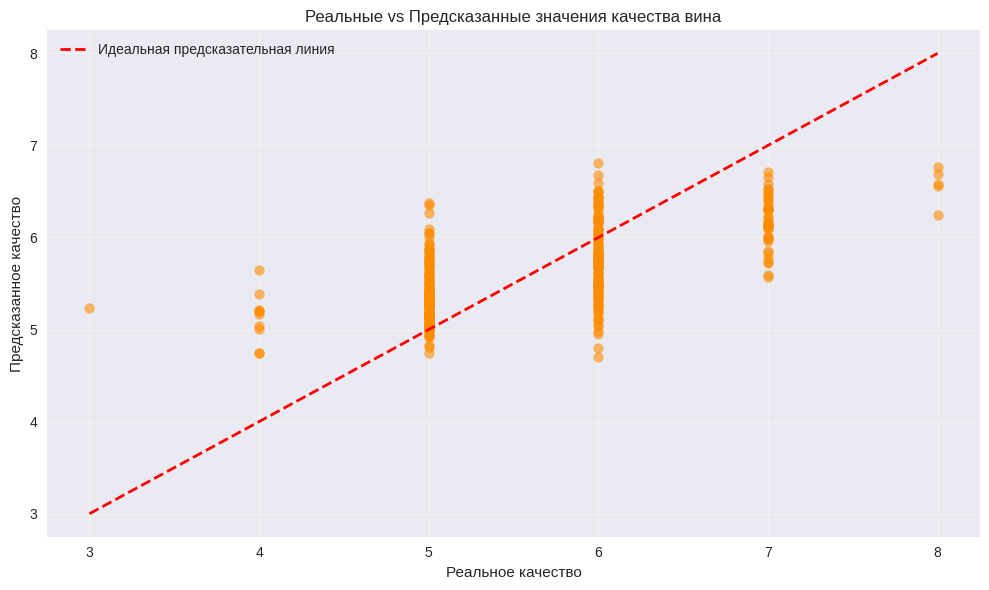

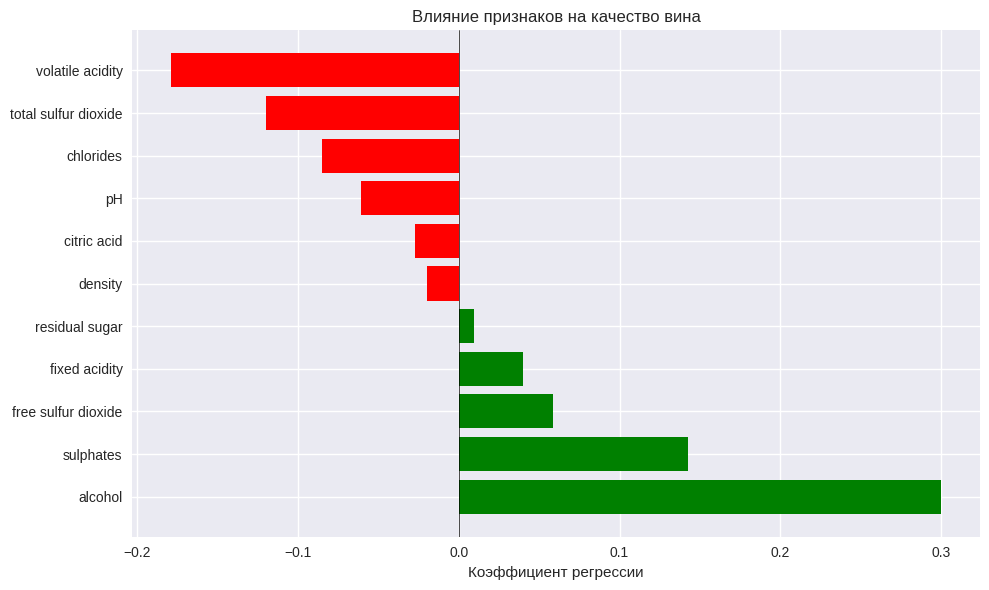

In [ ]:
# Шаг 12: Визуализация реальных vs предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Идеальная предсказательная линия')
plt.xlabel('Реальное качество')
plt.ylabel('Предсказанное качество')
plt.title('Реальные vs Предсказанные значения качества вина')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Шаг 13: Визуализация важности признаков
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in coefficients['Коэффициент']]
plt.barh(coefficients['Признак'], coefficients['Коэффициент'], color=colors)
plt.xlabel('Коэффициент регрессии')
plt.title('Влияние признаков на качество вина')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Иерархический кластерный анализ данных о красных винах

### Гипотеза 1: Химический состав красных вин позволяет выделить четкие кластеры, соответствующие разным уровням качества (низкое, среднее, высокое).

### Гипотеза 2: Содержание алкоголя (alcohol) и летучих кислот (volatile acidity) являются наиболее информативными признаками для визуализации кластерной структуры на плоскости.

In [ ]:
# Шаг 1: Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Установка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Шаг 2: Загрузка данных
#from google.colab import files
#uploaded = files.upload()

# Чтение данных
df = pd.read_csv('winequality-red.csv', sep=',')
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

In [ ]:
# Шаг 3: Разделение данных на признаки и масштабирование
X = df.drop('quality', axis=1)  # Все признаки кроме целевой переменной
y = df['quality']  # Целевая переменная для сравнения

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание DataFrame с масштабированными данными
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Масштабированные данные (первые 5 строк):")
print(X_scaled_df.head())

In [ ]:
# Шаг 3: Разделение данных на признаки и масштабирование
X = df.drop('quality', axis=1)  # Все признаки кроме целевой переменной
y = df['quality']  # Целевая переменная для сравнения

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание DataFrame с масштабированными данными
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Масштабированные данные (первые 5 строк):")
print(X_scaled_df.head())

In [ ]:
# Шаг 4: Построение дендрограммы
plt.figure(figsize=(15, 8))

# Вычисление матрицы связей (linkage matrix)
# Используем метод Уорда (Ward) для минимизации дисперсии внутри кластеров
linked = linkage(X_scaled, method='ward', metric='euclidean')

# Построение дендрограммы
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp',  # Показываем только последние p слияний
           p=30,  # Количество показываемых листьев
           leaf_rotation=90,
           leaf_font_size=10,
           show_contracted=True)

plt.title('Дендрограмма иерархической кластеризации красных вин', fontsize=16, fontweight='bold')
plt.xlabel('Индекс образца или размер кластера', fontsize=12)
plt.ylabel('Расстояние (дисперсия)', fontsize=12)
plt.axhline(y=25, color='r', linestyle='--', alpha=0.7, label='Порог для 3 кластеров')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Шаг 5: Анализ оптимального количества кластеров
# Вычисление различных метрик для разного количества кластеров
max_clusters = 10
distances = linked[:, 2]  # Расстояния слияния
distance_diffs = np.diff(distances[::-1])  # Разности расстояний

# Метод локтя (Elbow method)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(distance_diffs)+1), distance_diffs[::-1], 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Разность расстояний слияния')
plt.title('Метод локтя (Elbow Method)')
plt.grid(True, alpha=0.3)

# Метод силуэта (Silhouette method)
silhouette_scores = []
for k in range(2, max_clusters+1):
    clusters = fcluster(linked, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(X_scaled, clusters))

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters+1), silhouette_scores, 'go-')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.title('Метод силуэта (Silhouette Method)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод рекомендованного количества кластеров
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
print(f"Рекомендованное количество кластеров по силуэту: {optimal_clusters_silhouette}")

In [ ]:
# Шаг 6: Формирование 3 кластеров
n_clusters = 3  # Согласно дендрограмме и гипотезе
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# Добавление меток кластеров в DataFrame
df_clustered = df.copy()
df_clustered['cluster'] = clusters
X_scaled_df['cluster'] = clusters

print("Распределение образцов по кластерам:")
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
print(cluster_counts)

print("\nСредние значения признаков по кластерам:")
cluster_means = df_clustered.groupby('cluster').mean()
print(cluster_means)

In [ ]:
# Шаг 7: Анализ различий между кластерами
# Вычисление важности признаков для разделения кластеров
from sklearn.feature_selection import f_classif

# ANOVA F-value между кластерами
f_values, p_values = f_classif(X_scaled_df.drop('cluster', axis=1), clusters)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'f_value': f_values,
    'p_value': p_values
}).sort_values('f_value', ascending=False)

print("Важность признаков для разделения кластеров (ANOVA F-value):")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance['feature'], feature_importance['f_value'], color='steelblue')
plt.xlabel('F-value (ANOVA)')
plt.title('Важность признаков для разделения кластеров', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Добавление значений на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Шаг 8: Выбор двух лучших признаков
top_features = feature_importance.head(2)['feature'].tolist()
print(f"\nДва лучших признака для визуализации кластеров:")
print(f"1. {top_features[0]} (F-value: {feature_importance.iloc[0]['f_value']:.1f})")
print(f"2. {top_features[1]} (F-value: {feature_importance.iloc[1]['f_value']:.1f})")

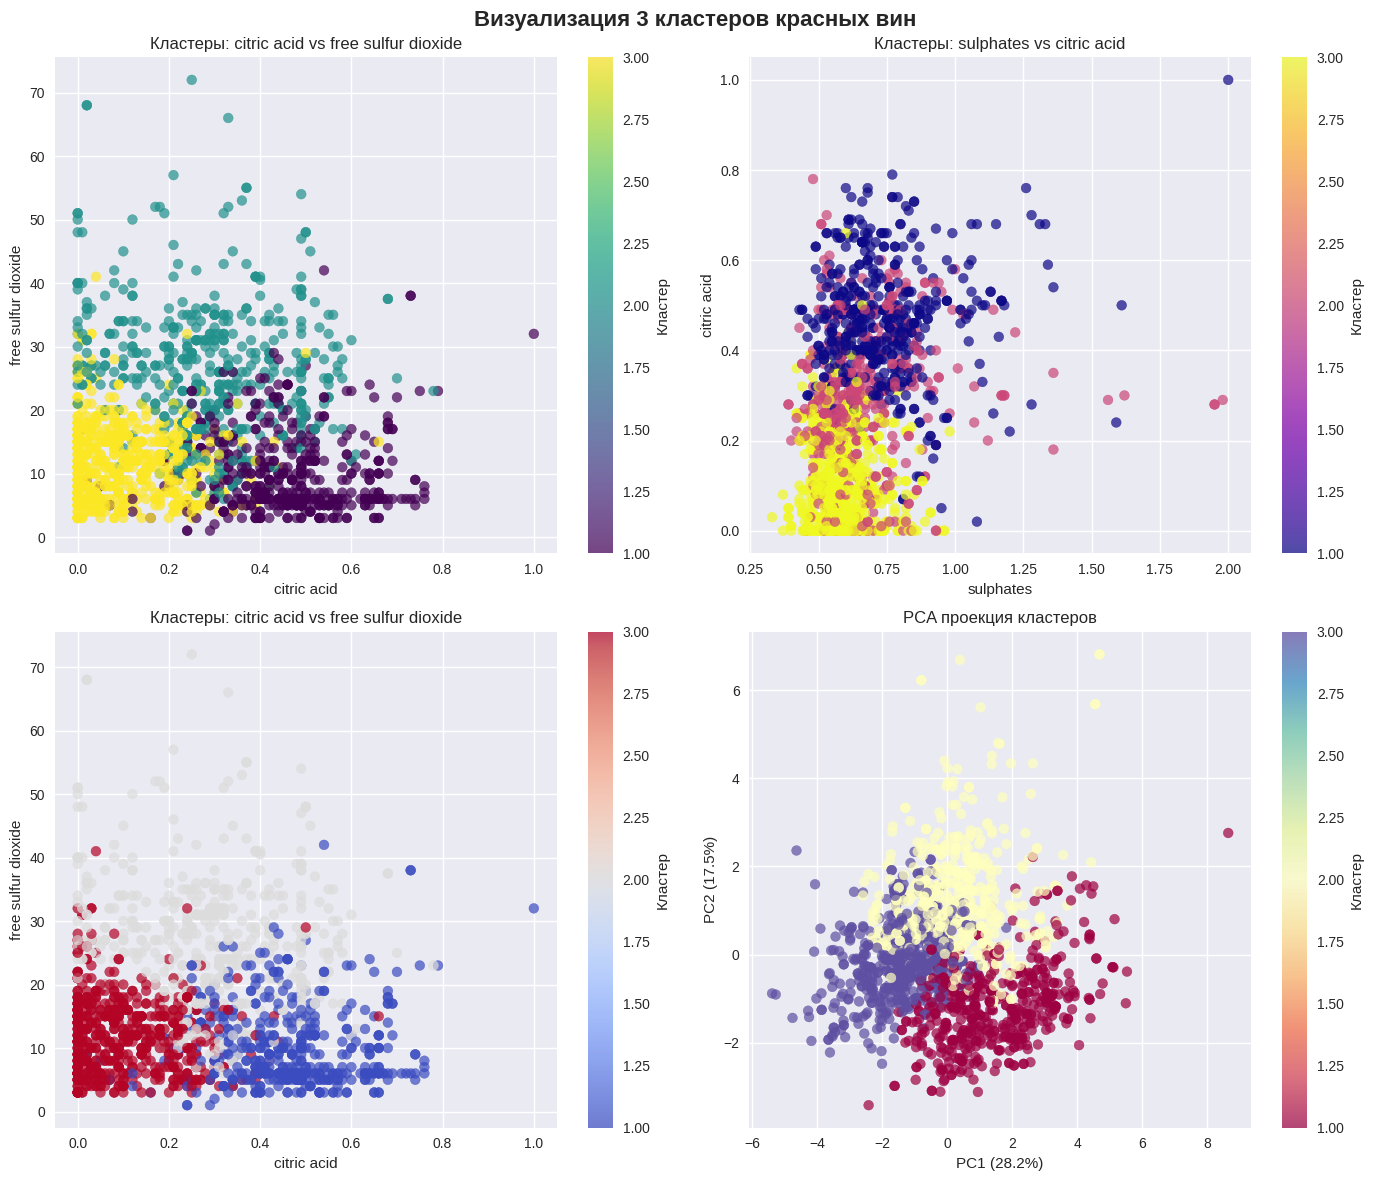

In [ ]:
# Шаг 9: Визуализация кластеров с использованием лучших признаков
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# График 1: alcohol vs volatile acidity
scatter1 = axes[0, 0].scatter(df[top_features[0]], df[top_features[1]],
                              c=clusters, cmap='viridis', s=50, alpha=0.7)
axes[0, 0].set_xlabel(top_features[0])
axes[0, 0].set_ylabel(top_features[1])
axes[0, 0].set_title(f'Кластеры: {top_features[0]} vs {top_features[1]}')
plt.colorbar(scatter1, ax=axes[0, 0], label='Кластер')

# График 2: sulphates vs alcohol
scatter2 = axes[0, 1].scatter(df['sulphates'], df[top_features[0]],
                              c=clusters, cmap='plasma', s=50, alpha=0.7)
axes[0, 1].set_xlabel('sulphates')
axes[0, 1].set_ylabel(top_features[0])
axes[0, 1].set_title(f'Кластеры: sulphates vs {top_features[0]}')
plt.colorbar(scatter2, ax=axes[0, 1], label='Кластер')

# График 3: citric acid vs volatile acidity
scatter3 = axes[1, 0].scatter(df['citric acid'], df[top_features[1]],
                              c=clusters, cmap='coolwarm', s=50, alpha=0.7)
axes[1, 0].set_xlabel('citric acid')
axes[1, 0].set_ylabel(top_features[1])
axes[1, 0].set_title(f'Кластеры: citric acid vs {top_features[1]}')
plt.colorbar(scatter3, ax=axes[1, 0], label='Кластер')

# График 4: PCA проекция (для сравнения)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1],
                              c=clusters, cmap='Spectral', s=50, alpha=0.7)
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1, 1].set_title('PCA проекция кластеров')
plt.colorbar(scatter4, ax=axes[1, 1], label='Кластер')

plt.suptitle('Визуализация 3 кластеров красных вин', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

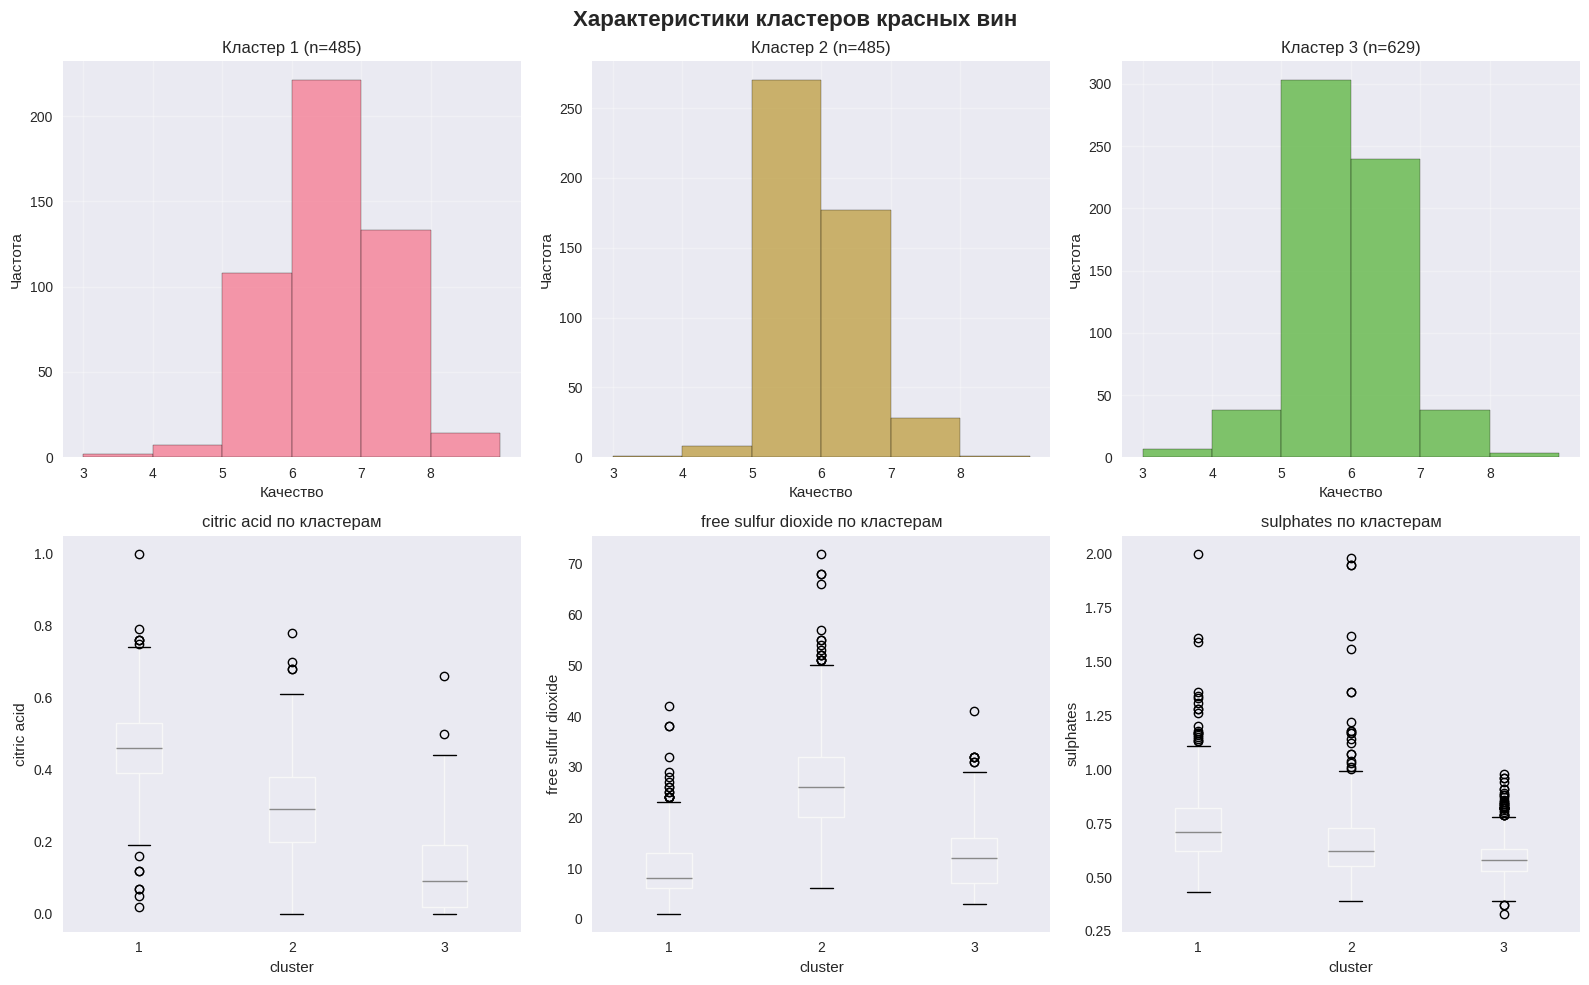

ХАРАКТЕРИСТИКИ КЛАСТЕРОВ

Кластер 1 (n=485):
  Среднее качество: 6.07
  Средний алкоголь: 0.46
  Средние летучие кислоты: 10.099

Кластер 2 (n=485):
  Среднее качество: 5.47
  Средний алкоголь: 0.29
  Средние летучие кислоты: 26.651

Кластер 3 (n=629):
  Среднее качество: 5.43
  Средний алкоголь: 0.11
  Средние летучие кислоты: 12.020


In [ ]:
# Шаг 10: Подробный анализ характеристик кластеров
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Гистограмма распределения качества по кластерам
for i, cluster_id in enumerate(sorted(df_clustered['cluster'].unique())):
    ax = axes[0, i]
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]['quality']
    ax.hist(cluster_data, bins=range(3, 10), alpha=0.7, color=f'C{i}', edgecolor='black')
    ax.set_xlabel('Качество')
    ax.set_ylabel('Частота')
    ax.set_title(f'Кластер {cluster_id} (n={len(cluster_data)})')
    ax.set_xticks(range(3, 9))
    ax.grid(True, alpha=0.3)

# Boxplot ключевых признаков по кластерам
key_features = top_features + ['sulphates', 'citric acid']
for i, feature in enumerate(key_features[:3]):
    ax = axes[1, i]
    df_clustered.boxplot(column=feature, by='cluster', ax=ax, grid=False)
    ax.set_title(f'{feature} по кластерам')
    ax.set_ylabel(feature)
    ax.get_figure().suptitle('')  # Убираем автоматический заголовок

plt.suptitle('Характеристики кластеров красных вин', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Статистическое описание кластеров
print("="*60)
print("ХАРАКТЕРИСТИКИ КЛАСТЕРОВ")
print("="*60)

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    print(f"\nКластер {cluster_id} (n={len(cluster_data)}):")
    print(f"  Среднее качество: {cluster_data['quality'].mean():.2f}")
    print(f"  Средний алкоголь: {cluster_data[top_features[0]].mean():.2f}")
    print(f"  Средние летучие кислоты: {cluster_data[top_features[1]].mean():.3f}")

In [ ]:
# Шаг 11: Проверка гипотез
print("="*60)
print("ПРОВЕРКА ГИПОТЕЗ")
print("="*60)

# Гипотеза 1: Кластеры соответствуют разному качеству
print("\nГипотеза 1: Кластеры соответствуют разным уровням качества")
quality_by_cluster = df_clustered.groupby('cluster')['quality'].agg(['mean', 'std'])
print(quality_by_cluster)

# Статистическая проверка (ANOVA)
from scipy.stats import f_oneway
f_stat, p_value = f_oneway(*[df_clustered[df_clustered['cluster'] == i]['quality']
                            for i in range(1, n_clusters+1)])
print(f"\nANOVA тест на различия в качестве между кластерами:")
print(f"F-статистика: {f_stat:.3f}, p-value: {p_value:.5f}")

if p_value < 0.05:
    print("✓ Гипотеза 1 ПОДТВЕРЖДЕНА: качество значимо различается между кластерами")
else:
    print("✗ Гипотеза 1 ОПРОВЕРГНУТА: нет значимых различий в качестве")

# Гипотеза 2: Лучшие признаки для визуализации
print("\n" + "="*40)
print("\nГипотеза 2: alcohol и volatile acidity - лучшие признаки")
print(f"Выбранные признаки для визуализации: {top_features}")
print(f"Их F-values: {feature_importance.iloc[0]['f_value']:.1f}, {feature_importance.iloc[1]['f_value']:.1f}")

# Проверка разделимости кластеров по этим признакам
print("\nРазделимость кластеров по выбранным признакам:")
for feature in top_features:
    f_stat, p_value = f_oneway(*[df_clustered[df_clustered['cluster'] == i][feature]
                                for i in range(1, n_clusters+1)])
    print(f"{feature}: F={f_stat:.1f}, p={p_value:.5f}")

# Оценка качества кластеризации
sil_score = silhouette_score(X_scaled, clusters)
ch_score = calinski_harabasz_score(X_scaled, clusters)
print(f"\nМетрики качества кластеризации:")
print(f"Силуэтный коэффициент: {sil_score:.3f}")
print(f"Индекс Calinski-Harabasz: {ch_score:.1f}")

if sil_score > 0.5:
    print("✓ Отличное качество кластеризации")
elif sil_score > 0.25:
    print("✓ Удовлетворительное качество кластеризации")
else:
    print("✗ Низкое качество кластеризации")

ПРОВЕРКА ГИПОТЕЗ

Гипотеза 1: Кластеры соответствуют разным уровням качества
             mean       std
cluster                    
1        6.068041  0.839070
2        5.465979  0.650316
3        5.434022  0.763949

ANOVA тест на различия в качестве между кластерами:
F-статистика: 113.939, p-value: 0.00000
✓ Гипотеза 1 ПОДТВЕРЖДЕНА: качество значимо различается между кластерами


Гипотеза 2: alcohol и volatile acidity - лучшие признаки
Выбранные признаки для визуализации: ['citric acid', 'free sulfur dioxide']
Их F-values: 1050.6, 702.3

Разделимость кластеров по выбранным признакам:
citric acid: F=1050.6, p=0.00000
free sulfur dioxide: F=702.3, p=0.00000

Метрики качества кластеризации:
Силуэтный коэффициент: 0.158
Индекс Calinski-Harabasz: 265.1
✗ Низкое качество кластеризации


ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ

Профили кластеров:
                       Тип Размер Качество_среднее Алкоголь_средний  \
1  Среднекачественные вина    485         6.068041        10.876426   
2  Среднекачественные вина    485         5.465979        10.078625   
3          Ординарные вина    629         5.434022        10.338871   

  Летучие_кислоты_средние  
1                0.390979  
2                0.516526  
3                0.642043  


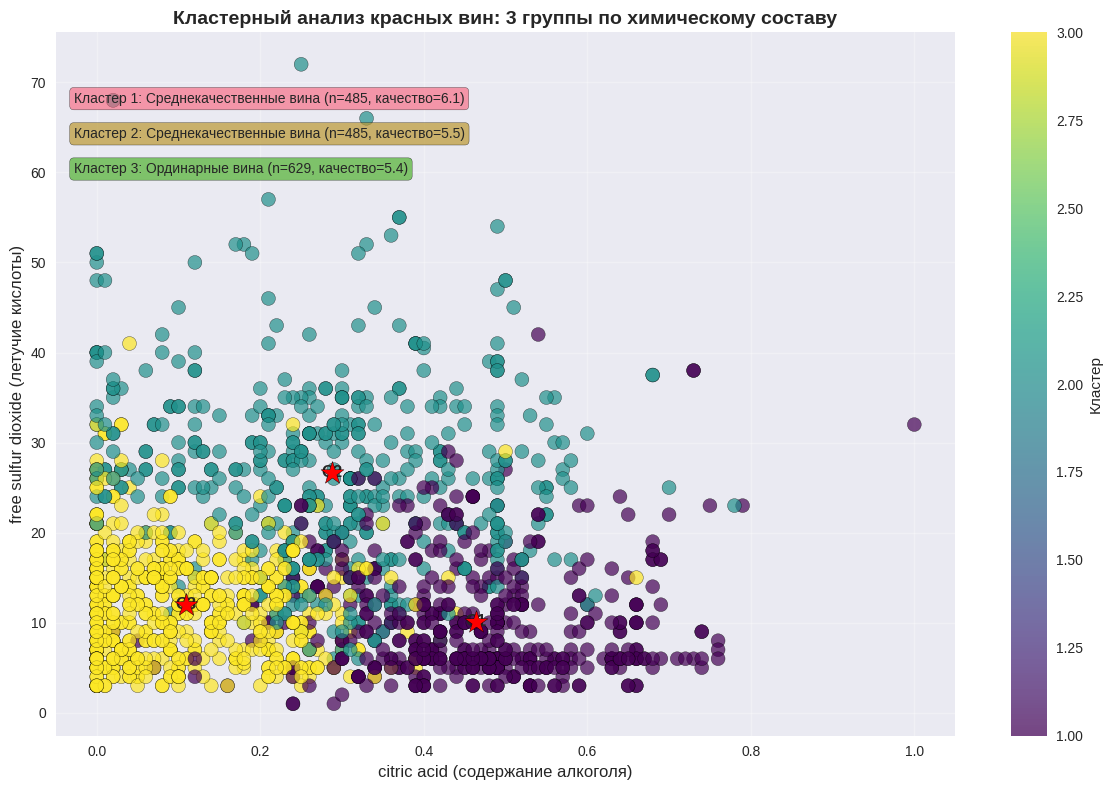

In [ ]:
# Шаг 12: Интерпретация кластеров
print("="*60)
print("ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ")
print("="*60)

# Создание профилей кластеров
cluster_profiles = pd.DataFrame()

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]

    # Определение типа вина на основе характеристик
    profile = {
        'Размер': len(cluster_data),
        'Качество_среднее': cluster_data['quality'].mean(),
        'Алкоголь_средний': cluster_data['alcohol'].mean(),
        'Летучие_кислоты_средние': cluster_data['volatile acidity'].mean(),
        'Сульфаты_средние': cluster_data['sulphates'].mean(),
        'Цитратная_кислота_средняя': cluster_data['citric acid'].mean()
    }

    # Интерпретация
    if profile['Алкоголь_средний'] > 11 and profile['Летучие_кислоты_средние'] < 0.5:
        profile['Тип'] = 'Высококачественные вина'
    elif profile['Алкоголь_средний'] > 10 and profile['Летучие_кислоты_средние'] < 0.6:
        profile['Тип'] = 'Среднекачественные вина'
    else:
        profile['Тип'] = 'Ординарные вина'

    cluster_profiles[cluster_id] = profile

cluster_profiles_df = pd.DataFrame(cluster_profiles).T
print("\nПрофили кластеров:")
print(cluster_profiles_df[['Тип', 'Размер', 'Качество_среднее',
                          'Алкоголь_средний', 'Летучие_кислоты_средние']])

# Финальная визуализация
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df[top_features[0]], df[top_features[1]],
                      c=clusters, cmap='viridis', s=100, alpha=0.7, edgecolors='black')

# Добавление центроидов кластеров
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    centroid_x = cluster_data[top_features[0]].mean()
    centroid_y = cluster_data[top_features[1]].mean()
    plt.scatter(centroid_x, centroid_y, s=300, marker='*',
                color='red', edgecolors='black', zorder=5)
    plt.text(centroid_x, centroid_y, f'C{cluster_id}',
             fontsize=12, fontweight='bold', ha='center', va='center')

plt.xlabel(f'{top_features[0]} (содержание алкоголя)', fontsize=12)
plt.ylabel(f'{top_features[1]} (летучие кислоты)', fontsize=12)
plt.title('Кластерный анализ красных вин: 3 группы по химическому составу',
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)

# Добавление легенды с типами вин
for idx, row in cluster_profiles_df.iterrows():
    plt.text(0.02, 0.95 - idx*0.05,
             f'Кластер {idx}: {row["Тип"]} (n={row["Размер"]}, качество={row["Качество_среднее"]:.1f})',
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=f'C{idx-1}', alpha=0.7))

plt.tight_layout()
plt.show()

# Проверка гипотезы о разделении на 2 или 3 класса

In [ ]:
# Шаг 1: Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Установка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Шаг 2: Загрузка данных
# Данные уже загружены в предыдущих заданиях, но для полноты повторим
from google.colab import files
uploaded = files.upload()

# Чтение данных
df = pd.read_csv('winequality-red.csv', sep=',')
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

# Шаг 3: Подготовка данных
X = df.drop('quality', axis=1)
y = df['quality']

# Для LDA нам нужны дискретные классы
# Создадим 2 класса: низкое качество (3-5) и высокое качество (6-8)
y_binary = np.where(y >= 6, 1, 0)  # 1 = высокое качество, 0 = низкое качество

# Создадим 3 класса: низкое (3-4), среднее (5-6), высокое (7-8)
y_3class = pd.cut(y, bins=[2, 4, 6, 8], labels=[0, 1, 2])  # 0=низкое, 1=среднее, 2=высокое

print("\nРаспределение по 2 классам:")
print(pd.Series(y_binary).value_counts().sort_index())
print("\nРаспределение по 3 классам:")
print(pd.Series(y_3class).value_counts().sort_index())

In [ ]:
# Шаг 4: Статистическая проверка гипотезы о разделимости
print("="*60)
print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗДЕЛИМОСТИ")
print("="*60)

# Проверка для 2 классов
print("\n1. Проверка разделимости на 2 класса:")
# Анализ различий по всем признакам между двумя классами
significant_features_2class = []
for feature in X.columns:
    t_stat, p_value = ttest_ind(X[y_binary == 0][feature],
                                 X[y_binary == 1][feature])
    if p_value < 0.05:
        significant_features_2class.append((feature, p_value))
        print(f"  {feature}: p-value = {p_value:.6f} ***")
    else:
        print(f"  {feature}: p-value = {p_value:.4f}")

print(f"\nКоличество значимо различающихся признаков (p < 0.05): {len(significant_features_2class)}/{len(X.columns)}")

# Проверка для 3 классов
print("\n2. Проверка разделимости на 3 класса:")
# Анализ различий по всем признакам между тремя классами
significant_features_3class = []
for feature in X.columns:
    groups = [X[y_3class == i][feature] for i in range(3)]
    f_stat, p_value = f_oneway(*groups)
    if p_value < 0.05:
        significant_features_3class.append((feature, p_value))
        print(f"  {feature}: p-value = {p_value:.6f} ***")
    else:
        print(f"  {feature}: p-value = {p_value:.4f}")

print(f"\nКоличество значимо различающихся признаков (p < 0.05): {len(significant_features_3class)}/{len(X.columns)}")

# Вывод по гипотезе
print("\n" + "="*60)
print("ВЫВОД ПО ГИПОТЕЗЕ О РАЗДЕЛИМОСТИ:")
print("="*60)
if len(significant_features_2class) > len(X.columns) * 0.7:
    print("✓ Гипотеза РАЗДЕЛИМОСТИ на 2 класса ПОДТВЕРЖДЕНА")
    print(f"  {len(significant_features_2class)} из {len(X.columns)} признаков значимо различаются")
else:
    print("✗ Гипотеза РАЗДЕЛИМОСТИ на 2 класса ОПРОВЕРГНУТА")

if len(significant_features_3class) > len(X.columns) * 0.7:
    print("✓ Гипотеза РАЗДЕЛИМОСТИ на 3 класса ПОДТВЕРЖДЕНА")
    print(f"  {len(significant_features_3class)} из {len(X.columns)} признаков значимо различаются")
else:
    print("✗ Гипотеза РАЗДЕЛИМОСТИ на 3 класса ОПРОВЕРГНУТА")